In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
if use_cuda: torch.cuda.set_device(device)
print(device)

cuda:0


# Load SMILES

In [4]:
PROPERTY_NAME = 'ABCG2'
input_dir_our = f"outputs_6-3_{PROPERTY_NAME}_translation"
input_dir_ctrl= "."
output_dir = f"outputs_6-4_{PROPERTY_NAME}_affinity_distribution"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 1. ours

In [5]:
df_our = pd.read_csv(os.path.join(input_dir_our, "results_sorafenib.csv"), header=None)
df_our = df_our.rename(columns={0:"source", 1:"target"})
df_our

,source,target
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC(C(F)(F)F)=...
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...
...,...,...
9995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...
9996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...
9997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...
9998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...


## 2. UGMMT

In [6]:
df_ctrl = pd.read_csv(os.path.join(input_dir_ctrl, "UGMMT_ABCG2_sorafenib.txt"), sep=" ", header=None)
df_ctrl = df_ctrl.rename(columns={0:"source", 1:"target"})
df_ctrl

,source,target
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CC(C)(C)O)NC(=O)NC1=CC=C(N2C=NC=N2)C(C(F)(F)F)=C1
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1COC2=CC=CC(C(F)(F)F)=C2)N=C1C1=CC=CN=C1
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)OC1=CC=C(Cl)C=C1COC1=CC=CC=C1C(=O)NC1=C...
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,FC(F)OC1=CC=C(NC(S)=NCCN2)C2=CC=CC=C2Cl)C=C1
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,COC1=CC=C(C2=CC=CC(NC(=O)C3=CC=CS3)=C2)N=N1
...,...,...
199995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,COC1=CC=C(C(=O)NCC2=CC=CC(NC(=O)C3=CC=CC=N3)=C...
199996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=C(OC(F)(F)F)C=C1)C1=CC=C2C=CC=CC2=N1
199997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=C2C=CN=CC2=C1)C1=CC=C(C2=CC=CC=C2)N=C1
199998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CC1=CC=C(NC(=O)CNC(=O)C2=CC=CC=N2)C=C1


# Similarity

In [7]:
df_our_sim = df_our.copy()
pbar = tqdm(enumerate(df_our.values), total=len(df_our))

for i, (smi_src, smi_tar) in pbar:
    ## mol
    mol_src = Chem.MolFromSmiles(smi_src)
    mol_tar = Chem.MolFromSmiles(smi_tar)
    ## fingerprint
    fp_src = AllChem.GetMorganFingerprintAsBitVect(mol_src, radius=2, nBits=2048, useChirality=False)
    fp_tar = AllChem.GetMorganFingerprintAsBitVect(mol_tar, radius=2, nBits=2048, useChirality=False)
    ## Tanimoto
    sim = DataStructs.TanimotoSimilarity(fp_src, fp_tar)
    df_our_sim.loc[i,"TANIMOTO"] = sim
    
df_our_sim

100%|██████████| 10000/10000 [00:03<00:00, 2657.95it/s]


,source,target,TANIMOTO
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC(C(F)(F)F)=...,0.426471
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625
...,...,...,...
9995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625
9996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271
9997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271
9998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625


In [8]:
records_ctrl = []
pbar = tqdm(enumerate(df_ctrl.values), total=len(df_ctrl))

for i, (smi_src, smi_tar) in pbar:
    try:
        ## mol
        mol_src = Chem.MolFromSmiles(smi_src)
        mol_tar = Chem.MolFromSmiles(smi_tar)
        ## fingerprint
        fp_src = AllChem.GetMorganFingerprintAsBitVect(mol_src, radius=2, nBits=2048, useChirality=False)
        fp_tar = AllChem.GetMorganFingerprintAsBitVect(mol_tar, radius=2, nBits=2048, useChirality=False)
        ## Tanimoto
        sim = DataStructs.TanimotoSimilarity(fp_src, fp_tar)
    except:
        sim = 0.
    if sim > 0.:
        records_ctrl.append((smi_src, smi_tar, sim))
    
    pbar.set_postfix({'len(records_ctrl)': len(records_ctrl)})
    if len(records_ctrl) == 10000:
        break
    
df_ctrl_sim = pd.DataFrame.from_records(records_ctrl)
df_ctrl_sim = df_ctrl_sim.rename(columns={0:"source", 1:"target", 2:"TANIMOTO"})
df_ctrl_sim

  1%|▏         | 2890/200000 [00:01<02:00, 1634.97it/s, len(records_ctrl)=2562]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 8390/200000 [00:05<01:51, 1719.20it/s, len(records_ctrl)=7247]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 11828/200000 [00:07<01:52, 1677.22it/s, len(records_ctrl)=1e+4]


,source,target,TANIMOTO
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1COC2=CC=CC(C(F)(F)F)=C2)N=C1C1=CC=CN=C1,0.162791
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)OC1=CC=C(Cl)C=C1COC1=CC=CC=C1C(=O)NC1=C...,0.253165
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,COC1=CC=C(C2=CC=CC(NC(=O)C3=CC=CS3)=C2)N=N1,0.202532
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=CC=C1)C1=CC=C(SC(F)F)C=C1,0.171429
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,NN(CC(=O)NC1=CC=C(OC)C=C1)C1=CC=C(F)C=C1,0.219178
...,...,...,...
9995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CCOC1=CC=CC(C(=O)NC2=CC=C(NC(=O)C3=CC=CO3)C=C2...,0.240000
9996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=C2C=CNC2=C1)C1=CC=CC(NC(=O)C2=CC=CC...,0.250000
9997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CC1=CC=C(C2=CC(C(=O)NC3=CC=C(OC(F)(F)F)C=C3)=C...,0.241758
9998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,C[S+]([O-])CC1=CC=C(NC(=O)C2=CC=CC=N2)C=C1,0.275362


# DeepPurpose

In [9]:
from DeepPurpose import DTI as models
from DeepPurpose.utils import *
from DeepPurpose.encoders import *

In [10]:
class VirtualScreening(object):
    def __init__(self, device):
        self.model = models.model_pretrained(model = 'MPNN_CNN_BindingDB')
        self.model.device = device
        
    def __call__(self, smi, aminoseq):
        list_smiles = [smi]
        list_aminoseq = [aminoseq]
        ## data preprocessing
        df_data = data_process_repurpose_virtual_screening(list_smiles,
                                                           list_aminoseq,
                                                           self.model.drug_encoding,
                                                           self.model.target_encoding,
                                                           'virtual screening')
        ## affinity prediction
        y_pred = self.model.predict(df_data)
        return y_pred

In [11]:
vs = VirtualScreening(device)

# Target proteins

In [12]:
targets = ["MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEEVWNIKQMIKLTQEHIEALLDKFGGEHNPPSIYLEAYEEYTSKLDALQQREQQLLESLGNGTDFSVSSSASMDTVTSSSSSSLSVLPSSLSVFQNPTDVARSNPKSPQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKALMMRGLIPECCAVYRIQDGEKKPIGWDTDISWLTGEELHVEVLENVPLTTHNFVRKTFFTLAFCDFCRKLLFQGFRCQTCGYKFHQRCSTEVPLMCVNYDQLDLLFVSKFFEHHPIPQEEASLAETALTSGSSPSAPASDSIGPQILTSPSPSKSIPIPQPFRPADEDHRNQFGQRDRSSSAPNVHINTIEPVNIDDLIRDQGFRGDGGSTTGLSATPPASLPGSLTNVKALQKSPGPQRERKSSSSSEDRNRMKTLGRRDSSDDWEIPDGQITVGQRIGSGSFGTVYKGKWHGDVAVKMLNVTAPTPQQLQAFKNEVGVLRKTRHVNILLFMGYSTKPQLAIVTQWCEGSSLYHHLHIIETKFEMIKLIDIARQTAQGMDYLHAKSIIHRDLKSNNIFLHEDLTVKIGDFGLATVKSRWSGSHQFEQLSGSILWMAPEVIRMQDKNPYSFQSDVYAFGIVLYELMTGQLPYSNINNRDQIIFMVGRGYLSPDLSKVRSNCPKAMKRLMAECLKKKRDERPLFPQILASIELLARSLPKIHRSASEPSLNRAGFQTEDFSLYACASPKTPIQAGGYGAFPVH",
           "MSSSNVEVFIPVSQGNTNGFPATASNDLKAFTEGAVLSFHNICYRVKLKSGFLPCRKPVEKEILSNINGIMKPGLNAILGPTGGGKSSLLDVLAARKDPSGLSGDVLINGAPRPANFKCNSGYVVQDDVVMGTLTVRENLQFSAALRLATTMTNHEKNERINRVIQELGLDKVADSKVGTQFIRGVSGGERKRTSIGMELITDPSILFLDEPTTGLDSSTANAVLLLLKRMSKQGRTIIFSIHQPRYSIFKLFDSLTLLASGRLMFHGPAQEALGYFESAGYHCEAYNNPADFFLDIINGDSTAVALNREEDFKATEIIEPSKQDKPLIEKLAEIYVNSSFYKETKAELHQLSGGEKKKKITVFKEISYTTSFCHQLRWVSKRSFKNLLGNPQASIAQIIVTVVLGLVIGAIYFGLKNDSTGIQNRAGVLFFLTTNQCFSSVSAVELFVVEKKLFIHEYISGYYRVSSYFLGKLLSDLLPMRMLPSIIFTCIVYFMLGLKPKADAFFVMMFTLMMVAYSASSMALAIAAGQSVVSVATLLMTICFVFMMIFSGLLVNLTTIASWLSWLQYFSIPRYGFTALQHNEFLGQNFCPGLNATGNNPCNYATCTGEEYLVKQGIDLSPWGLWKNHVALACMIVIFLTIAYLKLLFLKKYS"]

target_names = ["BRAF", # BRAF P15056
                "ABCG2"] # ABCG2 Q9UNQ0

In [13]:
filepath_output_ours = os.path.join(output_dir, "sorafenib_translation_COMA.csv")

if os.path.exists(filepath_output_ours):
    df_our_sim = pd.read_csv(filepath_output_ours)
else:
    for target_name, target_aminoseq in zip(target_names, targets):
        for i, smi in tqdm(enumerate(df_our_sim["target"]), total=len(df_our_sim)):
            df_our_sim.loc[i,f"affinity({target_name})"] = vs(smi, target_aminoseq)[0]
    df_our_sim.to_csv(filepath_output_ours, index=False)
    
df_our_sim

,source,target,TANIMOTO,affinity(BRAF),affinity(ABCG2)
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271,6.117706,4.948066
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC(C(F)(F)F)=...,0.426471,6.298387,4.670780
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746
...,...,...,...,...,...
9995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746
9996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271,6.117706,4.948066
9997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271,6.117706,4.948066
9998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746


In [14]:
((df_our_sim["TANIMOTO"] > 0.4) & (df_our_sim["affinity(ABCG2)"] < 4.7)).value_counts()

False    8263
True     1737
dtype: int64

In [15]:
df_our_sim_tmp = df_our_sim.drop_duplicates()
((df_our_sim_tmp["TANIMOTO"] > 0.4) & (df_our_sim_tmp["affinity(ABCG2)"] < 4.7)).value_counts()

False    151
True      19
dtype: int64

In [16]:
filepath_output_ctrl = os.path.join(output_dir, "sorafenib_translation_UGMMT.csv")

if os.path.exists(filepath_output_ctrl):
    df_ctrl_sim_pos = pd.read_csv(filepath_output_ctrl)
else:
    for target_name, target_aminoseq in zip(target_names, targets):
        for i, smi in tqdm(enumerate(df_ctrl_sim_pos["target"]), total=len(df_ctrl_sim_pos)):
            df_ctrl_sim_pos.loc[i,f"affinity({target_name})"] = vs(smi, target_aminoseq)[0]
    df_ctrl_sim_pos.to_csv(filepath_output_ctrl, index=False)
    
df_ctrl_sim_pos

,source,target,TANIMOTO,affinity(BRAF),affinity(ABCG2)
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1COC2=CC=CC(C(F)(F)F)=C2)N=C1C1=CC=CN=C1,0.162791,5.393579,4.983107
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)OC1=CC=C(Cl)C=C1COC1=CC=CC=C1C(=O)NC1=C...,0.253165,6.188442,4.498008
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,COC1=CC=C(C2=CC=CC(NC(=O)C3=CC=CS3)=C2)N=N1,0.202532,6.969235,4.602796
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=CC=C1)C1=CC=C(SC(F)F)C=C1,0.171429,6.487191,4.083781
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,NN(CC(=O)NC1=CC=C(OC)C=C1)C1=CC=C(F)C=C1,0.219178,6.068447,4.673386
...,...,...,...,...,...
9995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CCOC1=CC=CC(C(=O)NC2=CC=C(NC(=O)C3=CC=CO3)C=C2...,0.240000,6.169693,5.078282
9996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=C2C=CNC2=C1)C1=CC=CC(NC(=O)C2=CC=CC...,0.250000,6.872260,4.368650
9997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CC1=CC=C(C2=CC(C(=O)NC3=CC=C(OC(F)(F)F)C=C3)=C...,0.241758,6.601949,4.585801
9998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,C[S+]([O-])CC1=CC=C(NC(=O)C2=CC=CC=N2)C=C1,0.275362,6.561829,4.751066


In [17]:
((df_ctrl_sim_pos["TANIMOTO"] > 0.4) & (df_ctrl_sim_pos["affinity(ABCG2)"] < 4.7)).value_counts()

False    9992
True        8
dtype: int64

In [18]:
df_ctrl_sim_pos_tmp = df_ctrl_sim_pos.drop_duplicates()
((df_ctrl_sim_pos_tmp["TANIMOTO"] > 0.4) & (df_ctrl_sim_pos_tmp["affinity(ABCG2)"] < 4.7)).value_counts()

False    6763
True        4
dtype: int64

# Plots

In [5]:
df_merge = pd.concat([df_our_sim, df_ctrl_sim_pos], ignore_index=True)
df_merge.loc[:,"Label"] = ["COMA" for _ in range(len(df_our_sim))] + ["UGMMT" for _ in range(len(df_ctrl_sim_pos))]
df_merge

,source,target,TANIMOTO,affinity(BRAF),affinity(ABCG2),Label
0,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(OC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=...,0.576271,6.117706,4.948066,COMA
1,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746,COMA
2,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746,COMA
3,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC(C(F)(F)F)=...,0.426471,6.298387,4.670780,COMA
4,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CNC(=O)C1=CC(C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)=C...,0.390625,6.278000,4.228746,COMA
...,...,...,...,...,...,...
19995,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CCOC1=CC=CC(C(=O)NC2=CC=C(NC(=O)C3=CC=CO3)C=C2...,0.240000,6.169693,5.078282,UGMMT
19996,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,O=C(NC1=CC=C2C=CNC2=C1)C1=CC=CC(NC(=O)C2=CC=CC...,0.250000,6.872260,4.368650,UGMMT
19997,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,CC1=CC=C(C2=CC(C(=O)NC3=CC=C(OC(F)(F)F)C=C3)=C...,0.241758,6.601949,4.585801,UGMMT
19998,CNC(=O)C1=CC(OC2=CC=C(NC(=O)NC3=CC=C(Cl)C(C(F)...,C[S+]([O-])CC1=CC=C(NC(=O)C2=CC=CC=N2)C=C1,0.275362,6.561829,4.751066,UGMMT


In [6]:
sns.set_theme(style="darkgrid")

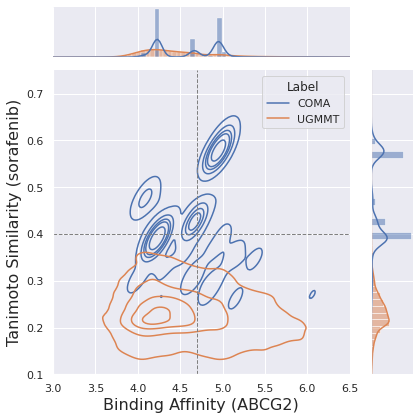

In [9]:
g = sns.JointGrid(y="TANIMOTO", x="affinity(ABCG2)", data=df_merge, hue="Label")
g.plot_joint(sns.kdeplot, levels=6)
g.plot_marginals(sns.histplot, kde=True, common_norm=False, stat="density")

axes = g.figure.get_axes()

axes[0].axvline(x=4.7, c='gray', linestyle='--', linewidth=1)
axes[0].axhline(y=0.4, c='gray', linestyle='--', linewidth=1)
axes[0].set_xlabel("Binding Affinity (ABCG2)", fontsize=16)
axes[0].set_ylabel("Tanimoto Similarity (sorafenib)", fontsize=16)

axes[0].set_xlim(3.0, 6.5)
axes[1].set_xlim(3.0, 6.5)
axes[0].set_ylim(0.1, 0.75)
axes[2].set_ylim(0.1, 0.75)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "scatter_affinitiy_tanimoto.png"), dpi=600)